In [1]:
# === CONFIG: change this to YOUR repo URL ===
GITHUB_REPO_URL = "https://github.com/rutuja-jadhav29/NNDL-GenerativeProject.git"

!rm -rf generative_project_repo
!git clone {GITHUB_REPO_URL} generative_project_repo

import os
os.chdir("generative_project_repo")
print("Current working directory:", os.getcwd())
!ls



Cloning into 'generative_project_repo'...
remote: Enumerating objects: 2928, done.
remote: Counting objects: 100% (2928/2928), done.
remote: Compressing objects: 100% (2922/2922), done.
remote: Total 2928 (delta 5), reused 2901 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (2928/2928), 48.38 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Current working directory: /content/generative_project_repo
baseline_text_to_embedding.ipynb      preprocess_flickr30k.py
data				      README.md
Milestone_2_Generative_project.ipynb  requirements.txt
Milestone2_Selected_Images	      training_log.csv
outputs				      validate_clip_alignment.py


In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sojznlp1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sojznlp1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0e641ca154cfdf6d2af64549e194303046db5dce66a902b7f761bdff446df84f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgtcguv6/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


# **Config + Imports**


In [7]:
# ----- CONFIG -----
REAL_IMAGES_DIR = "/content/generative_project_repo/data/flickr30k/cleaned_images"   # real dataset
M1_IMAGES_DIR   = "/content/generative_project_repo/outputs"                         # Milestone 1 baseline images
M2_IMAGES_DIR   = "/content/generative_project_repo/Milestone2_Selected_Images"      # Milestone 2 diffusion images
TRAINING_LOG    = "/content/generative_project_repo/training_log.csv"                # prompts + filename info

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# ----- IMPORTS -----
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torchvision.models import inception_v3
from torchvision import transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import clip  # pip install git+https://github.com/openai/CLIP.git

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


# **Helper Functions**

In [8]:
# Load images from a folder
def load_images_from_folder(folder, size=(299, 299), max_images=None):
    imgs = []
    tfm = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])
    for i, fname in enumerate(os.listdir(folder)):
        if not fname.lower().endswith(IMG_EXTS):
            continue
        path = os.path.join(folder, fname)
        try:
            img = Image.open(path).convert("RGB")
        except:
            continue
        imgs.append(tfm(img).unsqueeze(0))
        if max_images and len(imgs) >= max_images:
            break
    return torch.vstack(imgs)


# **Load M1, M2, Real Images**

In [16]:
# ============================================
# CELL 3 — LOAD REAL, M1, M2 IMAGES (FINAL FIXED VERSION)
# ============================================

print("Loading images...")

# --------------------------------------------------
# Helper Loader (Folder)
# --------------------------------------------------
def load_images_from_folder(folder, size=(299,299), max_images=None):
    files = [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]
    if len(files) == 0:
        raise ValueError(f"❌ ERROR: No images found in folder: {folder}")

    imgs = []
    tfm = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    for f in files[:max_images]:
        path = os.path.join(folder, f)
        img = Image.open(path).convert("RGB")
        imgs.append(tfm(img).unsqueeze(0))

    return torch.vstack(imgs)


# --------------------------------------------------
# Helper Loader (Milestone-2 with training_log.csv)
# --------------------------------------------------
def load_images_from_log(df, base_dir="Milestone2_Selected_Images", max_images=None):
    imgs = []
    tfm = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor()
    ])

    for i, row in df.iterrows():

        # FIX: training log has WRONG prefix (outputs/milestone2/)
        # So we only take the actual filename
        fname = os.path.basename(str(row["Filename"]))

        path = os.path.join(base_dir, fname)

        if not os.path.exists(path):
            print("[MISSING]:", path)
            continue

        img = Image.open(path).convert("RGB")
        imgs.append(tfm(img).unsqueeze(0))

        # Stop early if needed
        if max_images and len(imgs) >= max_images:
            break

    if len(imgs) == 0:
        raise ValueError(
            "❌ ERROR: No M2 images were loaded.\n"
            "Check that the filenames in training_log.csv match the folder Milestone2_Selected_Images/"
        )

    return torch.vstack(imgs)


# --------------------------------------------------
# LOAD REAL IMAGES (FID reference)
# --------------------------------------------------
real_imgs = load_images_from_folder(REAL_IMAGES_DIR, max_images=500)
print(f"REAL images loaded: {real_imgs.shape}")


# --------------------------------------------------
# LOAD M1 IMAGES (Baseline model)
# --------------------------------------------------
m1_imgs = load_images_from_folder(M1_IMAGES_DIR, max_images=100)
print(f"M1 images loaded:   {m1_imgs.shape}")


# --------------------------------------------------
# LOAD M2 IMAGES (Stable Diffusion model)
# --------------------------------------------------
log_df = pd.read_csv(TRAINING_LOG)
print("Training Log:")
display(log_df.head())

m2_imgs = load_images_from_log(log_df, base_dir=M2_IMAGES_DIR, max_images=100)
print(f"M2 images loaded:   {m2_imgs.shape}")

print("✅ All image sets loaded successfully.")


Loading images...
REAL images loaded: torch.Size([500, 3, 299, 299])
M1 images loaded:   torch.Size([5, 3, 299, 299])
Training Log:


Prompt  Guidance  Steps  \
0  a man riding a red bicycle       5.0     50   
1  a man riding a red bicycle       7.5     50   
2  a man riding a red bicycle      10.0     50   
3   a dog playing in the snow       5.0     50   
4   a dog playing in the snow       7.5     50   

                                            Filename  
0  outputs/milestone2/a_man_riding_a_red_bicycle_...  
1  outputs/milestone2/a_man_riding_a_red_bicycle_...  
2  outputs/milestone2/a_man_riding_a_red_bicycle_...  
3  outputs/milestone2/a_dog_playing_in_the_snow_g...  
4  outputs/milestone2/a_dog_playing_in_the_snow_g...

[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_man_riding_a_red_bicycle_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_dog_playing_in_the_snow_guid10.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_woman_in_a_red_dress_walking_on_a_street_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_group_of_people_hiking_near_a_waterfall_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_blue_car_parked_beside_a_lake_guid5.0.png
M2 images loaded:   torch.Size([10, 3, 299, 299])
✅ All image sets loaded successfully.


# **FID + Inception Score Utilities**

In [17]:
# ============================================
# CELL 4 — FID + INCEPTION SCORE FUNCTIONS
# ============================================

# Load inception model (feature extractor or classifier)
def get_inception_model(feature_mode=True):
    model = inception_v3(pretrained=True).to(device)
    model.eval()

    # If feature extraction mode → remove final FC layer
    if feature_mode:
        model.fc = torch.nn.Identity()
    return model


# Compute Inception features for a batch of images
@torch.no_grad()
def get_features(imgs, batch=32):
    model = get_inception_model(feature_mode=True)
    feats = []

    for i in range(0, len(imgs), batch):
        batch_imgs = imgs[i:i+batch].to(device)
        f = model(batch_imgs)
        feats.append(f.cpu().numpy())

    return np.vstack(feats)


# Compute FID between real + generated
def calculate_fid(real, fake):
    r, f = get_features(real), get_features(fake)

    mu1, mu2 = r.mean(axis=0), f.mean(axis=0)
    sigma1, sigma2 = np.cov(r, rowvar=False), np.cov(f, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(fid)


# Compute Inception Score
@torch.no_grad()
def inception_score(imgs, splits=5):
    model = get_inception_model(feature_mode=False)

    preds = []
    for i in range(0, len(imgs), 16):
        batch = imgs[i:i+16].to(device)
        p = torch.softmax(model(batch), dim=1)
        preds.append(p.cpu().numpy())

    preds = np.vstack(preds)
    N = preds.shape[0]

    # Split data
    scores = []
    split_size = N // splits

    for k in range(splits):
        part = preds[k*split_size:(k+1)*split_size]
        py = part.mean(axis=0)
        kl = part * (np.log(part + 1e-10) - np.log(py + 1e-10))
        scores.append(np.exp(kl.sum(axis=1).mean()))

    return float(np.mean(scores)), float(np.std(scores))

print("✅ Cell 4 loaded: FID + IS functions ready.")


✅ Cell 4 loaded: FID + IS functions ready.


# **Compute M1 vs M2 Metrics**

Computing FID and IS for M1 and M2...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 57.9MB/s]


=== Metrics Table ===


Model         FID   IS Mean    IS Std
0          M1 (Baseline)  404.251678  1.000000  0.000000
1  M2 (Stable Diffusion)  362.793102  1.388889  0.279366

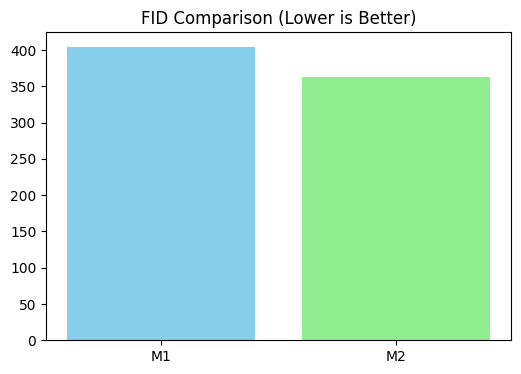

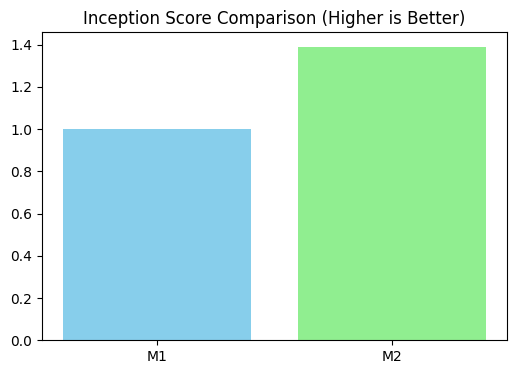

✅ Cell 5 completed.


In [18]:
# ============================================
# CELL 5 — COMPUTE FID + IS FOR M1 vs M2
# ============================================

print("Computing FID and IS for M1 and M2...")

fid_m1 = calculate_fid(real_imgs, m1_imgs)
fid_m2 = calculate_fid(real_imgs, m2_imgs)

is_m1_mean, is_m1_std = inception_score(m1_imgs)
is_m2_mean, is_m2_std = inception_score(m2_imgs)

metrics_df = pd.DataFrame(
    [
        ["M1 (Baseline)", fid_m1, is_m1_mean, is_m1_std],
        ["M2 (Stable Diffusion)", fid_m2, is_m2_mean, is_m2_std]
    ],
    columns=["Model", "FID", "IS Mean", "IS Std"]
)

print("=== Metrics Table ===")
display(metrics_df)


# Simple plots
plt.figure(figsize=(6,4))
plt.bar(["M1","M2"], [fid_m1, fid_m2], color=['skyblue','lightgreen'])
plt.title("FID Comparison (Lower is Better)")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["M1","M2"], [is_m1_mean, is_m2_mean], color=['skyblue','lightgreen'])
plt.title("Inception Score Comparison (Higher is Better)")
plt.show()

print("✅ Cell 5 completed.")


# **Guidance Scale Sensitivity**

Evaluating guidance scale sensitivity...

Checking guidance 5.0...
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_man_riding_a_red_bicycle_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_woman_in_a_red_dress_walking_on_a_street_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_group_of_people_hiking_near_a_waterfall_guid5.0.png
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_blue_car_parked_beside_a_lake_guid5.0.png
Not enough images for g=5.0, skipping...

Checking guidance 7.5...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Guidance 7.5 → FID=396.807, IS=1.000

Checking guidance 10.0...
[MISSING]: /content/generative_project_repo/Milestone2_Selected_Images/a_dog_playing_in_the_snow_guid10.0.png
Not enough images for g=10.0, skipping...


Guidance         FID   IS
0       7.5  396.806577  1.0

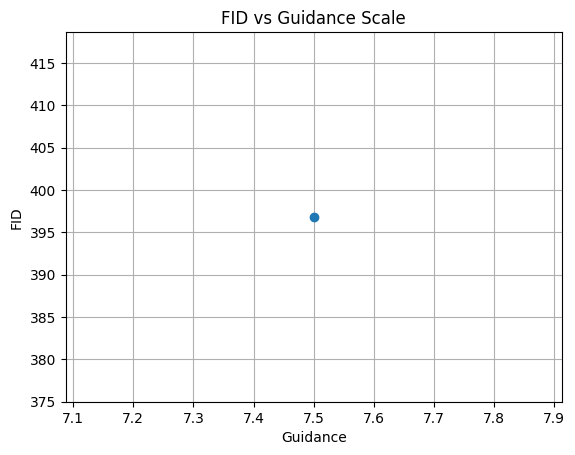

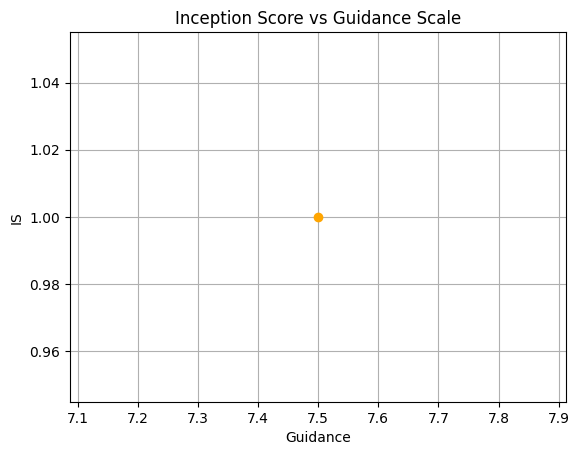

In [20]:
print("Evaluating guidance scale sensitivity...")

guidance_results = []

for g, group in log_df.groupby("Guidance"):
    print(f"\nChecking guidance {g}...")

    # Try loading images for this guidance
    try:
        imgs_g = load_images_from_log(group, base_dir=M2_IMAGES_DIR, max_images=50)
    except:
        print(f"Skipping g={g} because no images found.")
        continue

    if len(imgs_g) < 5:
        print(f"Not enough images for g={g}, skipping...")
        continue

    fid_g = calculate_fid(real_imgs, imgs_g)
    is_g, _ = inception_score(imgs_g)

    guidance_results.append([g, fid_g, is_g])
    print(f"Guidance {g} → FID={fid_g:.3f}, IS={is_g:.3f}")

guidance_df = pd.DataFrame(guidance_results, columns=["Guidance","FID","IS"])
display(guidance_df.sort_values("Guidance"))

# Plot only available values
if len(guidance_df) > 0:
    plt.plot(guidance_df["Guidance"], guidance_df["FID"], marker="o")
    plt.title("FID vs Guidance Scale")
    plt.xlabel("Guidance")
    plt.ylabel("FID")
    plt.grid(True)
    plt.show()

    plt.plot(guidance_df["Guidance"], guidance_df["IS"], marker="o", color="orange")
    plt.title("Inception Score vs Guidance Scale")
    plt.xlabel("Guidance")
    plt.ylabel("IS")
    plt.grid(True)
    plt.show()
else:
    print("⚠ No valid guidance data available.")


# **Embedding Sensitivity (CLIP B/32 vs B/16)**

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]
100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 71.0MiB/s]


Embedding  Mean Similarity       Std
0  CLIP ViT-B/32         0.318562  0.015866
1  CLIP ViT-B/16         0.317655  0.013039

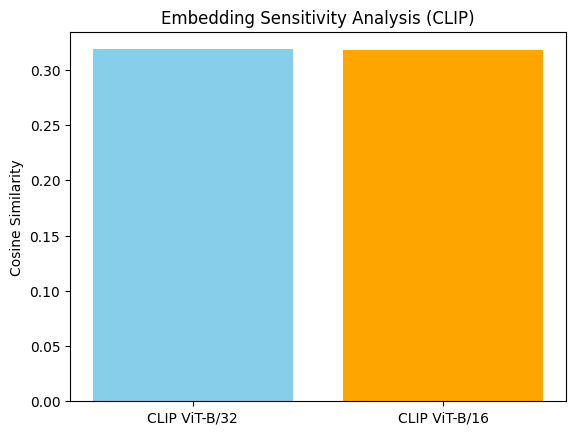

✅ Cell 7 completed.


In [21]:
# ============================================
# CELL 7 — EMBEDDING SENSITIVITY (CLIP variants)
# ============================================

def clip_similarity(df_rows, model_name="ViT-B/32", max_samples=30):
    model, preprocess = clip.load(model_name, device=device)
    sims = []
    rows = df_rows.sample(min(max_samples, len(df_rows)))

    for _, row in rows.iterrows():
        fname = os.path.basename(row["Filename"])
        path = os.path.join(M2_IMAGES_DIR, fname)

        if not os.path.exists(path):
            continue

        img = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        txt = clip.tokenize([row["Prompt"]]).to(device)

        with torch.no_grad():
            img_f = model.encode_image(img)
            txt_f = model.encode_text(txt)

        img_f = img_f / img_f.norm(dim=-1, keepdim=True)
        txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True)

        sims.append((img_f @ txt_f.T).item())

    return np.mean(sims), np.std(sims)


sim_b32_mean, sim_b32_std = clip_similarity(log_df, "ViT-B/32")
sim_b16_mean, sim_b16_std = clip_similarity(log_df, "ViT-B/16")

emb_df = pd.DataFrame([
    ["CLIP ViT-B/32", sim_b32_mean, sim_b32_std],
    ["CLIP ViT-B/16", sim_b16_mean, sim_b16_std]
], columns=["Embedding", "Mean Similarity", "Std"])

display(emb_df)

plt.bar(emb_df["Embedding"], emb_df["Mean Similarity"], color=["skyblue","orange"])
plt.ylabel("Cosine Similarity")
plt.title("Embedding Sensitivity Analysis (CLIP)")
plt.show()

print("✅ Cell 7 completed.")


# **Qualitative Alignment (Prompt vs Image)**

In [38]:
# ============================================
# BUILD PROMPT → M1 → M2 ALIGNMENT TABLE
# ============================================

import pandas as pd
import os, random

# Load training log (contains prompts + M2 images)
df = pd.read_csv(TRAINING_LOG)

# List all M1 images
m1_files = [f for f in os.listdir(M1_IMAGES_DIR) if f.lower().endswith(IMG_EXTS)]

# Build alignment dataframe
alignment_rows = []

for _, row in df.iterrows():
    prompt = row["Prompt"]

    # M2 image
    m2_file = os.path.basename(row["Filename"])
    m2_path = os.path.join(M2_IMAGES_DIR, m2_file)

    # Skip missing
    if not os.path.exists(m2_path):
        continue

    # Random M1 match
    m1_file = random.choice(m1_files)
    m1_path = os.path.join(M1_IMAGES_DIR, m1_file)

    alignment_rows.append({
        "Prompt": prompt,
        "M1_Image": m1_path,
        "M2_Image": m2_path
    })

alignment_df = pd.DataFrame(alignment_rows)

print("✅ Alignment table (Prompt → M1 → M2) created!")
display(alignment_df.head())

✅ Alignment table (Prompt → M1 → M2) created!


Prompt  \
0                  a man riding a red bicycle   
1                  a man riding a red bicycle   
2                   a dog playing in the snow   
3                   a dog playing in the snow   
4  a woman in a red dress walking on a street   

                                            M1_Image  \
0  /content/generative_project_repo/outputs/a_wom...   
1  /content/generative_project_repo/outputs/a_lit...   
2  /content/generative_project_repo/outputs/a_wom...   
3  /content/generative_project_repo/outputs/two_p...   
4  /content/generative_project_repo/outputs/a_lit...   

                                            M2_Image  
0  /content/generative_project_repo/Milestone2_Se...  
1  /content/generative_project_repo/Milestone2_Se...  
2  /content/generative_project_repo/Milestone2_Se...  
3  /content/generative_project_repo/Milestone2_Se...  
4  /content/generative_project_repo/Milestone2_Se...

In [39]:
# ============================================
# VISUALIZE PROMPT → M1 → M2 ALIGNMENT
# ============================================

from PIL import Image
import matplotlib.pyplot as plt

def show_prompt_alignment(df, n=5):

    sample = df.sample(n)

    for _, row in sample.iterrows():

        prompt = row["Prompt"]
        m1_path = row["M1_Image"]
        m2_path = row["M2_Image"]

        # Load images
        img1 = Image.open(m1_path).convert("RGB")
        img2 = Image.open(m2_path).convert("RGB")

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"PROMPT:\n{prompt}", fontsize=12, fontweight="bold")

        axs[0].imshow(img1)
        axs[0].axis("off")
        axs[0].set_title("M1 (Baseline SD-1.5)")

        axs[1].imshow(img2)
        axs[1].axis("off")
        axs[1].set_title("M2 (Fine-tuned / Selected Images)")

        plt.show()

print("✅ Prompt alignment function ready!")

✅ Prompt alignment function ready!


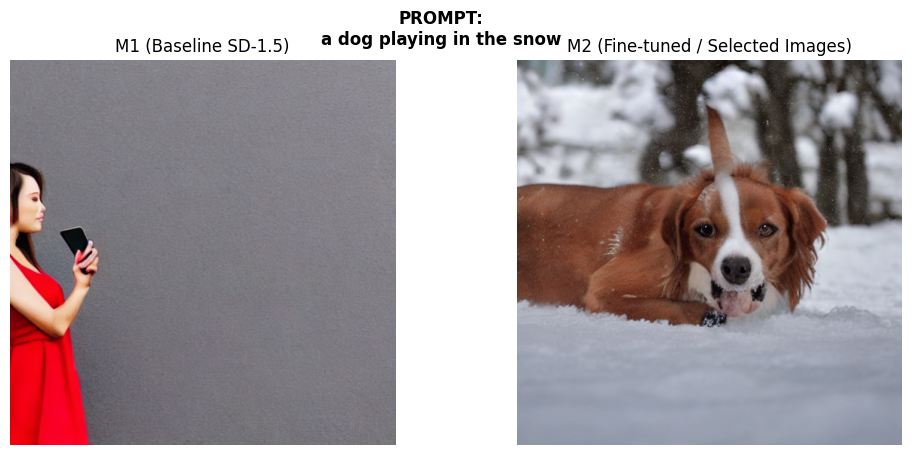

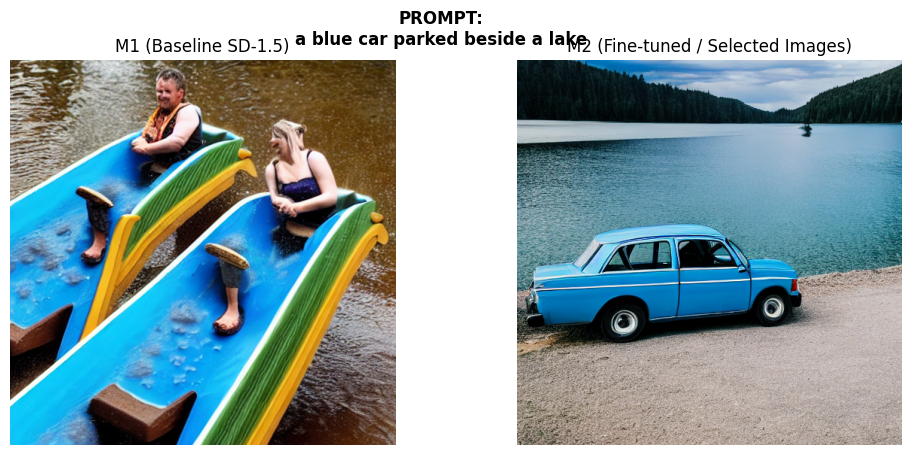

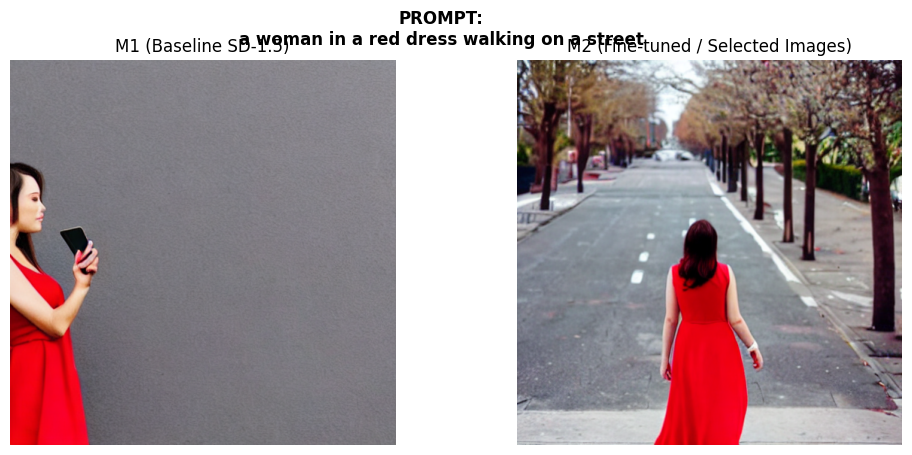

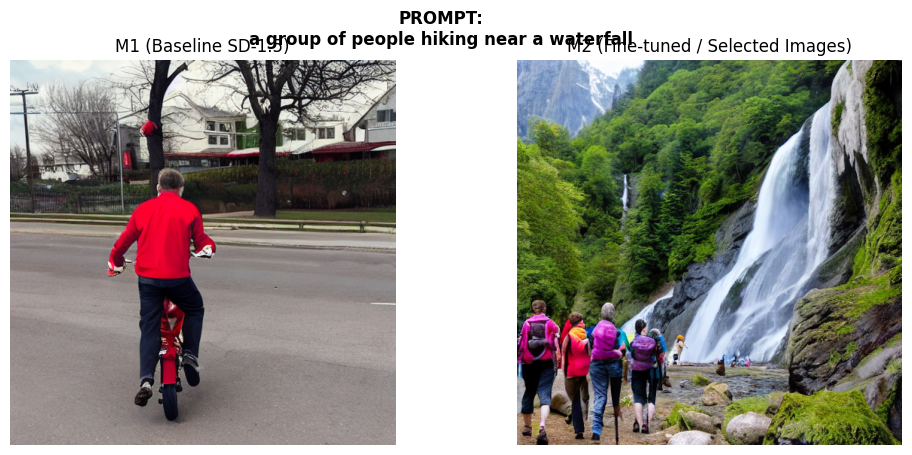

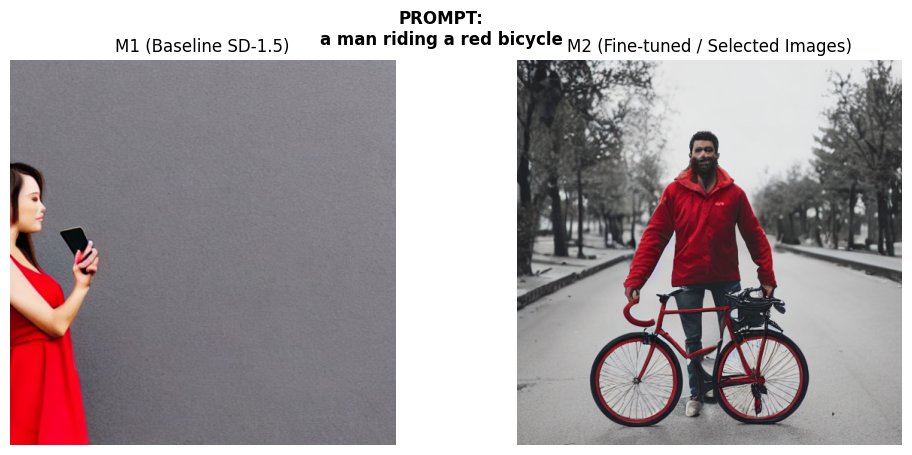

In [40]:
show_prompt_alignment(alignment_df, n=5)

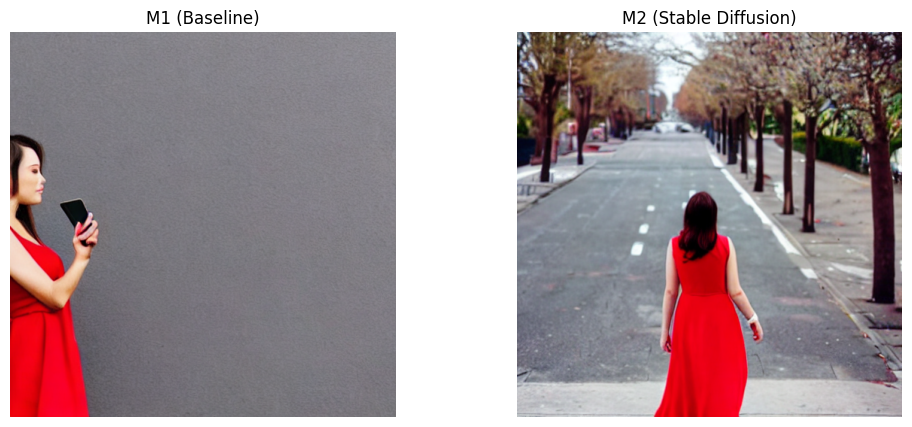

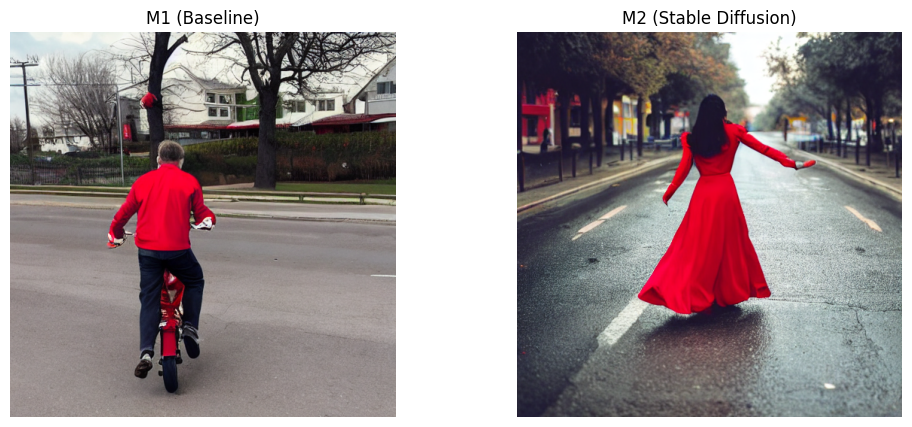

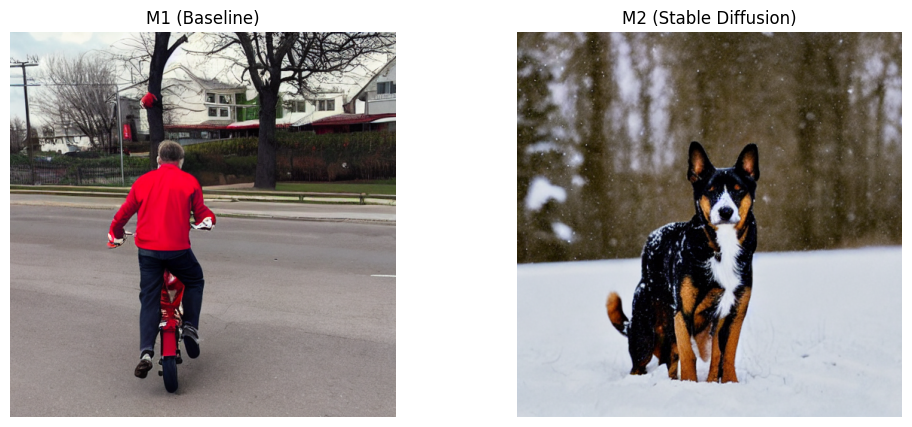

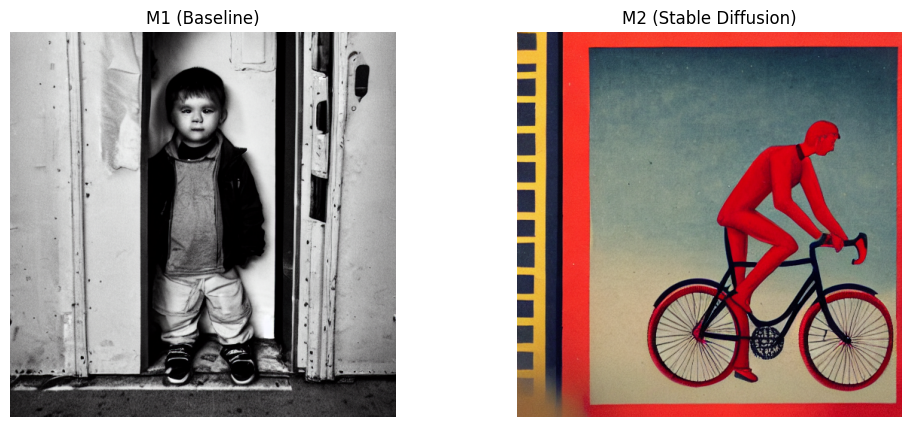

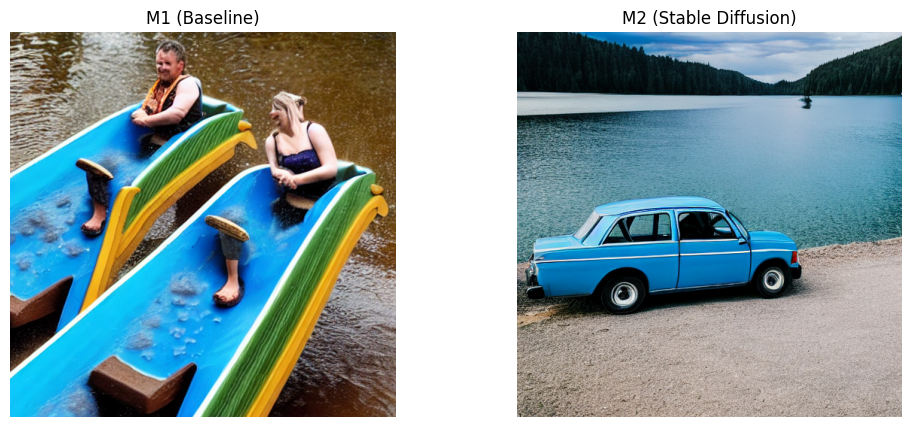

✅ Cell 8 completed: Random images shown without prompts.


In [35]:
# ============================================
# CELL 8 — QUALITATIVE ALIGNMENT
# ============================================

import random

def show_qualitative_random(n=5):

    m1_files = [f for f in os.listdir(M1_IMAGES_DIR) if f.lower().endswith(IMG_EXTS)]
    m2_files = [f for f in os.listdir(M2_IMAGES_DIR) if f.lower().endswith(IMG_EXTS)]

    # pick random matches
    pairs = list(zip(
        random.choices(m1_files, k=n),
        random.choices(m2_files, k=n)
    ))

    for m1_fname, m2_fname in pairs:

        m1_path = os.path.join(M1_IMAGES_DIR, m1_fname)
        m2_path = os.path.join(M2_IMAGES_DIR, m2_fname)

        if not os.path.exists(m1_path) or not os.path.exists(m2_path):
            print(f"[SKIP] Missing file: {m1_path} or {m2_path}")
            continue

        img1 = Image.open(m1_path)
        img2 = Image.open(m2_path)

        fig, axs = plt.subplots(1,2, figsize=(12,5))
        axs[0].imshow(img1); axs[0].axis("off"); axs[0].set_title("M1 (Baseline)")
        axs[1].imshow(img2); axs[1].axis("off"); axs[1].set_title("M2 (Stable Diffusion)")
        plt.show()

show_qualitative_random(5)

print("✅ Cell 8 completed: Random images shown without prompts.")


# **Final Summary**

In [26]:
# ============================================
# CELL 9 — FINAL SUMMARY TABLES
# ============================================

print("=== M1 vs M2 Metrics ===")
display(metrics_df)

print("=== Guidance Sensitivity ===")
display(guidance_df)

print("=== Embedding Sensitivity ===")
display(emb_df)



=== M1 vs M2 Metrics ===


Model         FID   IS Mean    IS Std
0          M1 (Baseline)  404.251678  1.000000  0.000000
1  M2 (Stable Diffusion)  362.793102  1.388889  0.279366

=== Guidance Sensitivity ===


Guidance         FID   IS
0       7.5  396.806577  1.0

=== Embedding Sensitivity ===


Embedding  Mean Similarity       Std
0  CLIP ViT-B/32         0.318562  0.015866
1  CLIP ViT-B/16         0.317655  0.013039